In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Library Python**

In [ ]:
!pip install -U --pre efficientnet
from efficientnet.tfkeras import EfficientNetB1
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import tensorflow
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import random
import os

     |████████████████████████████████| 50 kB 3.8 MB/s 


# **Defenisi Variabel**

In [ ]:
IMAGE_WIDTH=240
IMAGE_HEIGHT=240
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# **Persiapan Dataset**

**Data Train**

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Data Sampah 2/TRAIN"
lists_dir = os.listdir(path)
categories = []
file_name = []
for folder in lists_dir:
    files = os.listdir(path +"/"+folder)
    for file in files:
        path_file = path + "/" + folder + "/" + file
        file_name.append(path_file)
        categories.append(folder)

df = {"image": file_name,"categories": categories}
data = pd.DataFrame(df, index = None)
data = data.sample(frac=1)
data.head(5)

,image,categories
698,/content/drive/MyDrive/Colab Notebooks/Data Sa...,A
2650,/content/drive/MyDrive/Colab Notebooks/Data Sa...,O
475,/content/drive/MyDrive/Colab Notebooks/Data Sa...,A
917,/content/drive/MyDrive/Colab Notebooks/Data Sa...,A
1281,/content/drive/MyDrive/Colab Notebooks/Data Sa...,A


**Data Test**

In [ ]:
path_datatest = "/content/drive/MyDrive/Colab Notebooks/Data Sampah 2/TEST"
lists_dir_datatest = os.listdir(path_datatest)
categories_datatest = []
file_name_datatest = []
for folder in lists_dir_datatest:
    files = os.listdir(path_datatest +"/"+folder)
    for file in files:
        path_file = path_datatest + "/" + folder + "/" + file
        file_name_datatest.append(path_file)
        categories_datatest.append(folder)

df_datatest = {"image": file_name_datatest,"categories":categories_datatest}
data_datatest = pd.DataFrame(df_datatest, index = None)
data_datatest = data_datatest.sample(frac=1)
nb_samples=data_datatest.shape[0]
data_datatest

,image,categories
190,/content/drive/MyDrive/Colab Notebooks/Data Sa...,O
286,/content/drive/MyDrive/Colab Notebooks/Data Sa...,O
103,/content/drive/MyDrive/Colab Notebooks/Data Sa...,A
70,/content/drive/MyDrive/Colab Notebooks/Data Sa...,A
154,/content/drive/MyDrive/Colab Notebooks/Data Sa...,O
...,...,...
176,/content/drive/MyDrive/Colab Notebooks/Data Sa...,O
54,/content/drive/MyDrive/Colab Notebooks/Data Sa...,A
280,/content/drive/MyDrive/Colab Notebooks/Data Sa...,O
108,/content/drive/MyDrive/Colab Notebooks/Data Sa...,A


# **Total Data**

**Total data train pada tipa kelas**

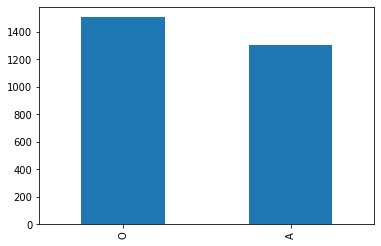

In [ ]:
data['categories'].value_counts().plot.bar()

**Total keseluruhan dataset**

In [ ]:
total_dataset=len(data_datatest)+len(data)
"Total dataset sampah :{} Sampah".format(total_dataset)

'Total dataset sampah :3123 Sampah'

# **Split Data**

In [ ]:
data["categories"] = data["categories"].replace({0: 'Anorganik', 1: 'Organik'}) 

**Pembagian data train dan data validasi**

In [ ]:
train_df, validate_df = train_test_split(data, test_size=0.10, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

**Visualisasi data train**

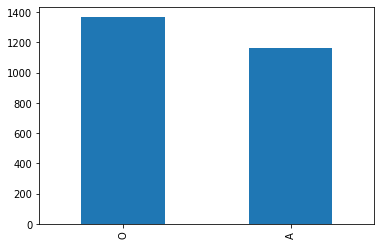

In [ ]:
train_df['categories'].value_counts().plot.bar()

In [ ]:
len(train_df)

2529

**Visualisasi data validasi**

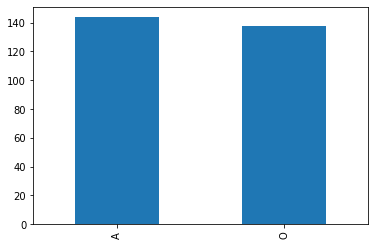

In [ ]:
validate_df['categories'].value_counts().plot.bar()

In [ ]:
len(validate_df)

282

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=64

# **Traning Generator** 

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    vertical_flip=True,
)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, 
    directory=path, 
    x_col='image',
    y_col='categories',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 2529 validated image filenames belonging to 2 classes.


# **Validasi Generator**

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validate_df, 
    directory=path, 
    x_col='image',
    y_col='categories',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 282 validated image filenames belonging to 2 classes.


# **Visualisasi Data Augmentasi**

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    dataframe=example_df, 
    dir=path, 
    x_col='image',
    y_col='categories',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


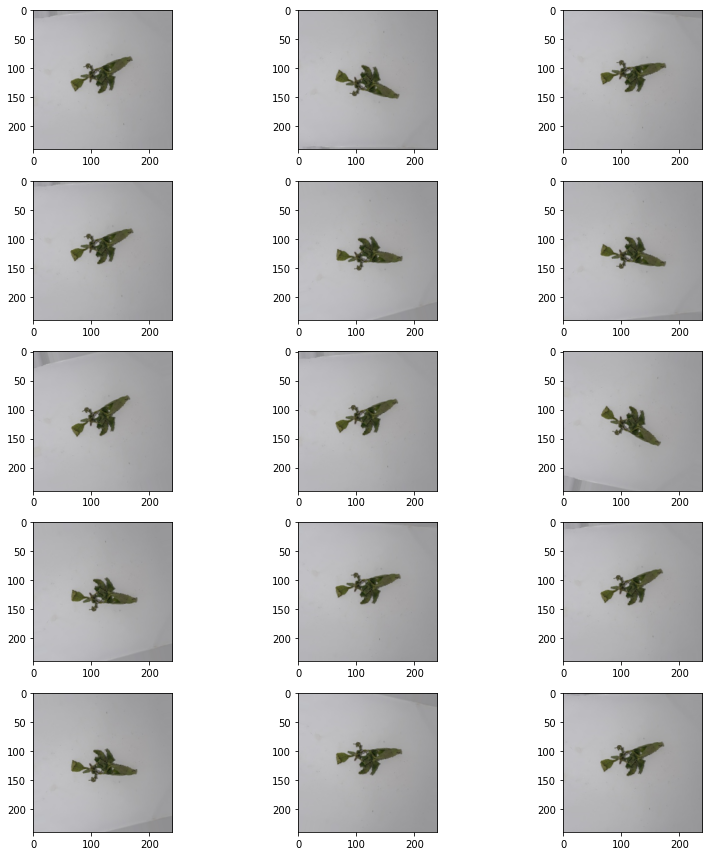

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# **Arsitektur EfficientNet-B1 model Noisy Student**

In [ ]:
base_model = EfficientNetB1(input_shape=(240,240,3), 
                                 include_top=False,
                                 weights='noisy-student')

27025408/27010080 [==============================] - 1s 0us/step


# **Freeze Arsitektur**

In [ ]:
for layer in base_model.layers:
    layer.trainable=False

# **Penambahan Layer Fully Connected Layer**






In [ ]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(640,kernel_size=(1,1)))
model.add(Flatten())
model.add(Dense(320,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(tensorflow.keras.layers.ReLU())
model.add(Dropout(0.2))
model.add(Dense(2,activation='softmax'))

# **Compile Model**

In [ ]:
OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=OPT)

# **Training Model**

In [24]:
epochs=25
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
)

Epoch 1/25
39/39 [==============================] - 280s 7s/step - loss: 0.2604 - accuracy: 0.9091 - val_loss: 0.5637 - val_accuracy: 0.8633
Epoch 2/25
39/39 [==============================] - 237s 6s/step - loss: 0.2285 - accuracy: 0.9132 - val_loss: 0.3030 - val_accuracy: 0.9062
Epoch 3/25
39/39 [==============================] - 238s 6s/step - loss: 0.2118 - accuracy: 0.9221 - val_loss: 0.2742 - val_accuracy: 0.9062
Epoch 4/25
39/39 [==============================] - 240s 6s/step - loss: 0.1924 - accuracy: 0.9270 - val_loss: 0.3627 - val_accuracy: 0.9102
Epoch 5/25
39/39 [==============================] - 247s 6s/step - loss: 0.1767 - accuracy: 0.9335 - val_loss: 0.2224 - val_accuracy: 0.9180
Epoch 6/25
39/39 [==============================] - 249s 6s/step - loss: 0.1740 - accuracy: 0.9371 - val_loss: 0.2446 - val_accuracy: 0.9102
Epoch 7/25
39/39 [==============================] - 246s 6s/step - loss: 0.1387 - accuracy: 0.9481 - val_loss: 0.2451 - val_accuracy: 0.9141
Epoch 8/25
39

#**Save Model**

In [26]:
model.save("modelsave.hdf5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


#**Visualisasi Hasil Training Data**

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

#**Test Generator**

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    dataframe=data_datatest, 
    dir=path_datatest, 
    x_col='image',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

# **Prediksi**#

In [ ]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
predicted_classes=np.argmax(predict,axis=1)
predicted_classes

In [ ]:
true_classes=np.array(data_datatest['categories'].replace(['O','A'],[1,0]))
true_classes

In [ ]:
class_labels=['0','1']
class_labels

# **Confusion Matrix**

In [ ]:
cm = confusion_matrix(true_classes, predicted_classes) 
cm

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ['Anorganik','Organik'], 
                     columns = ['Anorganik','Organik'])

plt.figure(figsize=(13,10))
sns.heatmap(cm_df, annot=True)
plt.title('CNN EfficientNet-B1 \nAccuracy:{0:.3f}'.format(accuracy_score(true_classes, predicted_classes)))
plt.ylabel('Label Sebenarnya')
plt.xlabel('Label Prediksi')
plt.show()

# **Evaluasi F1-Score**

In [ ]:
report=metrics.classification_report(true_classes, predicted_classes,target_names=class_labels)
print(report)